# Saturated Gradients

From the ablation experiments, we can see that IG assigns higher attribution scores than AP, but some of these attribution scores are overestimated. AP also underestimates the attribution scores for some heads!

- IG has more true positives, but also more false positives: IG has higher recall, but AP has higher precision.
- Overall the results between the methods are very similar.

What causes false positives in IG?

In [1]:
# Set up

%load_ext autoreload
%autoreload 2

import torch
import random
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_device, get_act_name
import numpy as np
import matplotlib.pyplot as plt

from attribution_methods import run_from_layer_fn, compute_layer_to_output_attributions
from testing import Task, TaskDataset, logit_diff_metric, identify_outliers, test_single_ablated_performance
from plotting import plot_attn, plot_attn_comparison, plot_correlation, plot_correlation_comparison, plot_bar_chart

from split_ig import SplitIntegratedGradients, SplitLayerIntegratedGradients, compute_layer_to_output_attributions_split_ig, split_integrated_gradients

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


## Output shapes

Hypothesis: outliers overestimated by IG are due to the shape of output curve in between the baseline and inputs to IG.

- IG calculates change in loss based on integrating gradients between two input values.
- A high attribution score could be caused by strong gradients (sensitivity) up until an intermediate input value (in between the two input values). In this case, the highlighted component would be important for the task "in between" (represented by different counterfactual inputs) instead of the target task.

![Overestimation](reference/overestimation.png)

To test this, we can visualise the gradients for intervals which are summed up by IG. We focus on attention head (9, 6) because it is highlighted more strongly by IG than by AP.

In [37]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=10)

clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-0.0307, -0.9269, -0.4937,  2.2320,  0.6754,  4.0447, -0.1785,  1.1947,
         1.1514,  1.7507], device='cuda:0')
Corrupted logit difference: tensor([-0.0387, -0.9451, -0.5103,  2.2153,  0.6299, -3.2074, -0.1823,  1.1766,
        -3.0072,  1.7392], device='cuda:0')


In [12]:
from captum.attr._utils.approximation_methods import approximation_parameters

n_steps = 50

def visualise_attn_interpolated_outputs(target_layer_num, target_pos, sample_idx):
    hook_name = get_act_name("result", target_layer_num)
    visualise_interpolated_integrated_gradients(hook_name, target_layer_num, target_pos, sample_idx)


def visualise_mlp_interpolated_outputs(target_layer_num, target_pos, sample_idx):
    hook_name = get_act_name("pos", target_layer_num)
    visualise_interpolated_integrated_gradients(hook_name, target_layer_num, target_pos, sample_idx)    


def visualise_interpolated_integrated_gradients(hook_name, target_layer_num, target_pos, sample_idx):
    target_layer = model.hook_dict[hook_name]
    layer_clean_input = clean_cache[hook_name][sample_idx] # Baseline

    # Only corrupt at target head
    layer_corrupt_input = layer_clean_input.clone()
    layer_corrupt_input[:, target_pos] = corrupted_cache[hook_name][:, target_pos]

    # Take the model starting from the target layer
    clean_input_sample = clean_input[sample_idx]
    forward_fn = lambda x: run_from_layer_fn(model, clean_input_sample, target_layer, x, logit_diff_metric, labels)
    _, alphas_func = approximation_parameters("gausslegendre")
    alphas = alphas_func(n_steps)

    with torch.autograd.set_grad_enabled(True):
        interpolated_inputs = [clean_input_sample + alpha * (layer_corrupt_input - layer_clean_input) for alpha in alphas]
        outputs = [forward_fn(i) for i in interpolated_inputs]

    plt.title(f"Model output at interpolated gradients: {(target_layer_num, target_pos)}")
    plt.plot(alphas, [o.item() for o in outputs])
    plt.xlabel("Interpolation coefficient")
    plt.ylabel("Output (logit difference)")
    plt.ylim(0, 6)
    plt.show()

In [5]:
ig_mlp = torch.load("results/aligned/ioi/ig_mlp.pt")
ig_attn = torch.load("results/aligned/ioi/ig_attn.pt")

ap_mlp = torch.load("results/aligned/ioi/ap_mlp.pt")
ap_attn = torch.load("results/aligned/ioi/ap_attn.pt")

# Identify disagreements between the two attribution methods

scaled_ig_attn = ig_attn * 1e5
scaled_ig_attn = ig_attn * 1e5
attn_outliers = []
for i in range(ig_attn.size(0)):
    outliers = identify_outliers(scaled_ig_attn[i], ap_attn[i])
    attn_outliers.append(outliers)

scaled_ig_mlp = ig_mlp * 1e5
mlp_outliers = []
for i in range(ig_mlp.size(0)):
    outliers = identify_outliers(scaled_ig_mlp[i], ap_mlp[i])
    mlp_outliers.append(outliers)

In [13]:
for layer, idx in attn_outliers[0]:
    visualise_attn_interpolated_outputs(layer, idx, 0)

for layer_idx, in mlp_outliers[0]:
    visualise_mlp_interpolated_outputs(layer, idx, 0)

RuntimeError: expand(torch.cuda.FloatTensor{[10, 12, 768]}, size=[21, 768]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)

## Split Integrated Gradients

The shape of outputs in integrated gradients suggests that IG may overestimate some attribution values due to saturated gradients at interpolated inputs. To confirm this, we run SplitIG (which cuts off the interpolated inputs if the gradients are saturated) and examine the level of agreement.

### Sanity check: no splitting

We check that Split IG with a split ratio of 1 (i.e. no splitting) produces the same result as regular IG, for a random attention head (5, 5).

In [30]:
hook_name = get_act_name("result", 5)
target_layer = model.hook_dict[hook_name]
prev_layer_hook = get_act_name("z", 5)
prev_layer = model.hook_dict[prev_layer_hook]

layer_clean_input = clean_cache[prev_layer_hook]
layer_corrupt_input = corrupted_cache[prev_layer_hook]

# Shape [batch, seq_len, d_head, d_model]
left_ig, _, _ = compute_layer_to_output_attributions_split_ig(
    model, clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, logit_diff_metric, labels, ratio=1)

original_attributions = compute_layer_to_output_attributions(
    model, clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, logit_diff_metric, labels
)

assert torch.allclose(left_ig, original_attributions.detach().cpu()), f"Split IG does not produce expected IG result"


Error (delta) for blocks.5.attn.hook_result attribution: tensor([-1.4855e-06, -2.8685e-06, -8.1956e-07,  9.6858e-07,  8.3148e-06,
        -1.0133e-06, -4.9733e-07,  5.9605e-07, -1.7047e-05,  8.4937e-07,
        -1.8105e-06,  1.2636e-05, -1.1921e-06, -5.7369e-07,  1.1399e-06,
         9.7975e-07,  2.1420e-07,  2.6822e-07, -2.2352e-08, -5.0478e-07,
         1.7541e-06,  1.5516e-06, -2.7567e-07, -1.8254e-06,  3.0920e-07,
         9.7789e-07,  2.8387e-06,  3.8147e-06, -1.7378e-06,  6.0489e-07,
         3.1255e-06,  1.0766e-06, -4.5449e-07,  1.4603e-06,  5.2433e-07,
        -2.6599e-06,  8.1062e-06,  4.6380e-07, -6.3330e-08,  2.0862e-07,
         2.6450e-07, -7.8678e-06,  6.1467e-08, -6.7335e-07, -6.9477e-07,
        -8.9873e-07,  2.1700e-07, -4.9174e-07, -9.8906e-07,  9.2983e-06],
       device='cuda:0')


Verify that Split IG at ratio 1 produces the same outputs as standard IG.

In [ ]:
from captum.attr import LayerIntegratedGradients

n_samples = clean_tokens.size(0)
forward_fn = lambda x: run_from_layer_fn(model, clean_tokens, prev_layer, x, logit_diff_metric, labels)

split_ig = SplitLayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
split_ig_attributions, _, _, interpolated_inputs = split_ig.attribute(inputs=layer_corrupt_input,
                                baselines=layer_clean_input,
                                internal_batch_size=n_samples, # Needs to match patching shape
                                attribute_to_layer_input=False,
                                return_convergence_delta=False)
# split_ig_attributions = split_ig_attributions.reshape((n_samples, 50,) + split_ig_attributions.shape[1:])
split_ig_attributions = np.reshape(split_ig_attributions.detach().cpu().numpy(), (n_samples, 50,) + split_ig_attributions.shape[1:], order='F')
split_ig_attributions = torch.tensor(split_ig_attributions).to(device).sum(dim=1)

ig_embed = LayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
ig_attributions = ig_embed.attribute(inputs=layer_corrupt_input,
                                baselines=layer_clean_input, 
                                internal_batch_size=n_samples,
                                attribute_to_layer_input=False,
                                return_convergence_delta=False)

assert torch.allclose(split_ig_attributions, ig_attributions), f"Split IG does not produces same output as IG"

### Run Split IG

We run Split IG on the same IOI dataset, using a split ratio of 0.9.

In [ ]:
ioi_split_ig_mlp, ioi_split_ig_attn = split_integrated_gradients(
    model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels, ratio=0.9
)

torch.save(ioi_split_ig_mlp, "results/saturated/ioi_split_ig_mlp.pt")
torch.save(ioi_split_ig_attn, "results/saturated/ioi_split_ig_attn.pt")

### Analysis

In [43]:
ioi_ig_mlp = torch.load("results/aligned/ioi/ig_mlp.pt")
ioi_ig_attn = torch.load("results/aligned/ioi/ig_attn.pt")

ioi_ap_mlp = torch.load("results/aligned/ioi/ap_mlp.pt")
ioi_ap_attn = torch.load("results/aligned/ioi/ap_attn.pt")

ioi_split_ig_mlp = torch.load("results/saturated/ioi_split_ig_mlp.pt")
ioi_split_ig_attn = torch.load("results/saturated/ioi_split_ig_attn.pt")

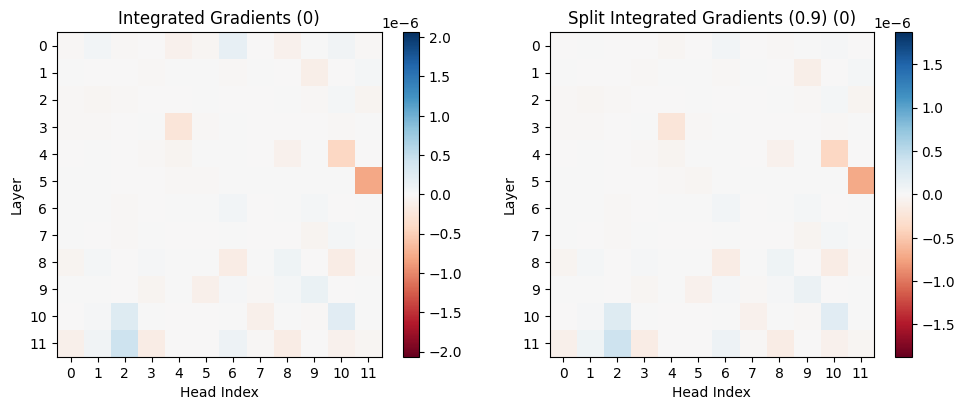

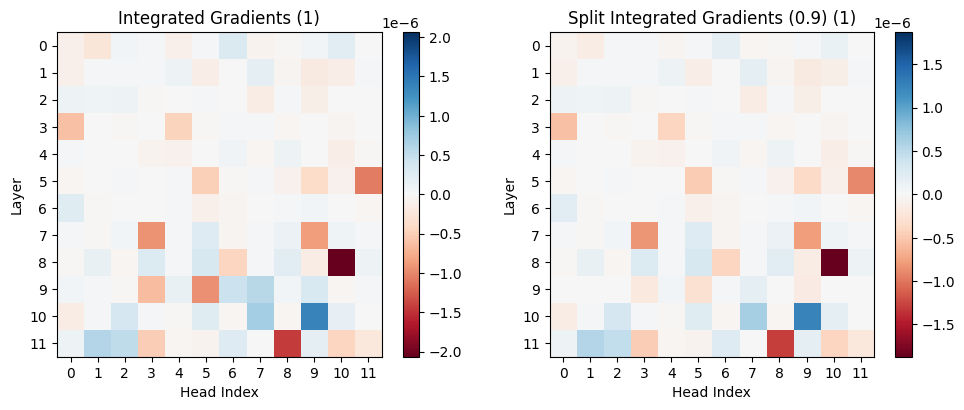

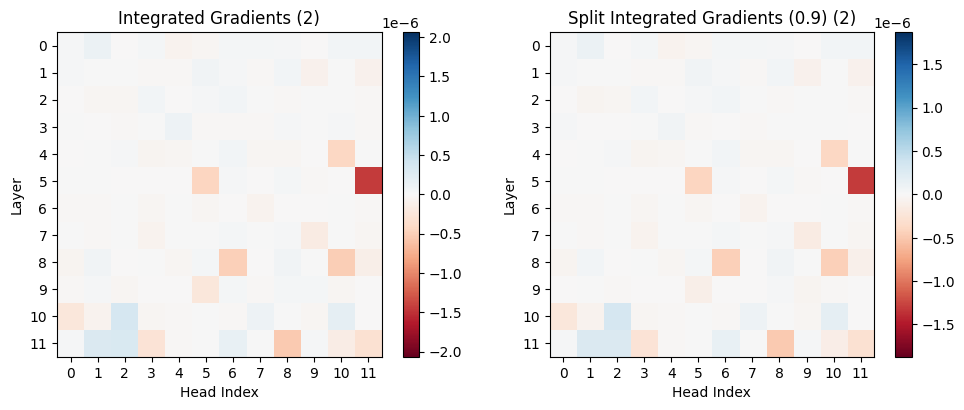

In [22]:
plot_attn_comparison(ioi_ig_attn[:3], ioi_split_ig_attn[:3], model, "Integrated Gradients", "Split Integrated Gradients (0.9)")

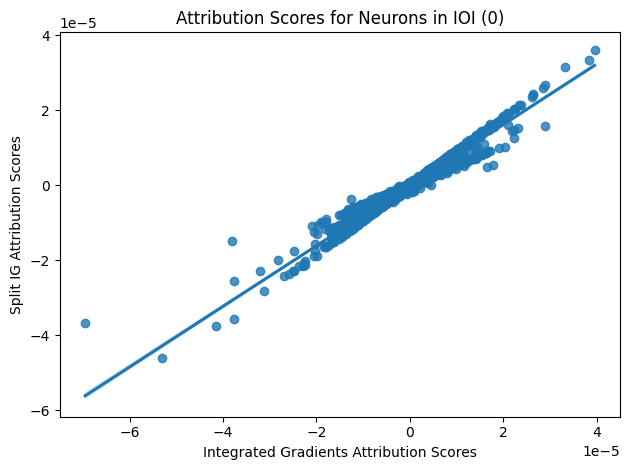

Correlation coefficient: 0.9807007526762983


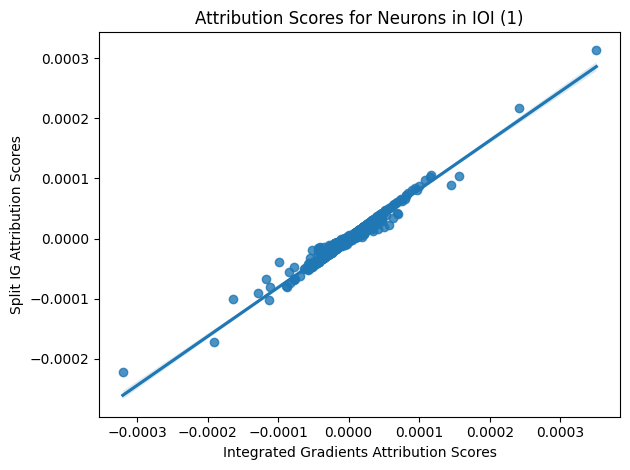

Correlation coefficient: 0.9864677438015572


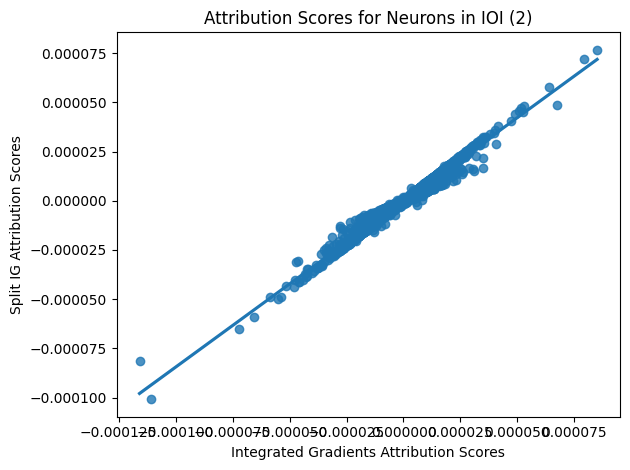

Correlation coefficient: 0.9903470419224117


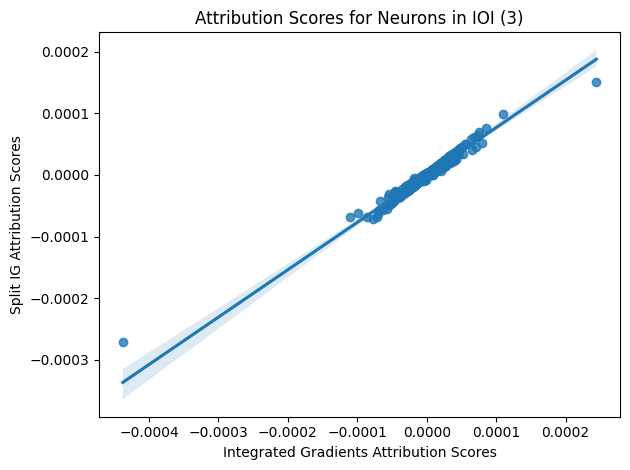

Correlation coefficient: 0.9835705191209227


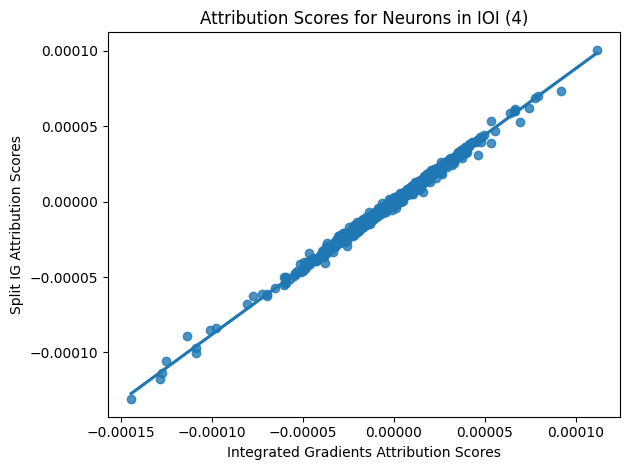

Correlation coefficient: 0.9981524942875428


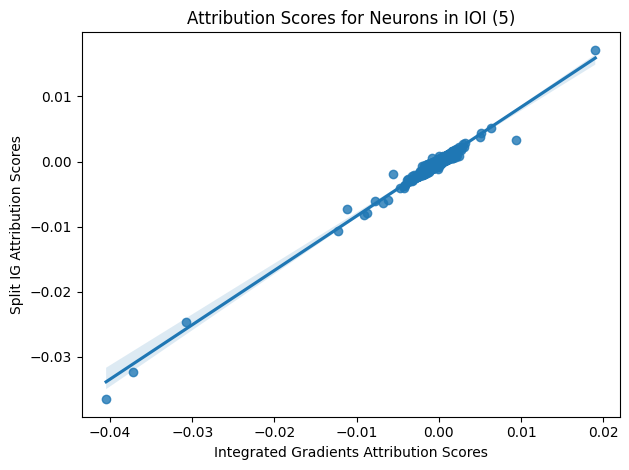

Correlation coefficient: 0.986905691320947


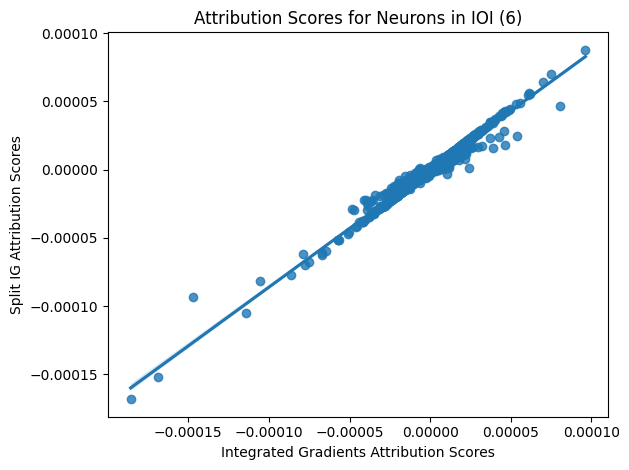

Correlation coefficient: 0.9906380270016631


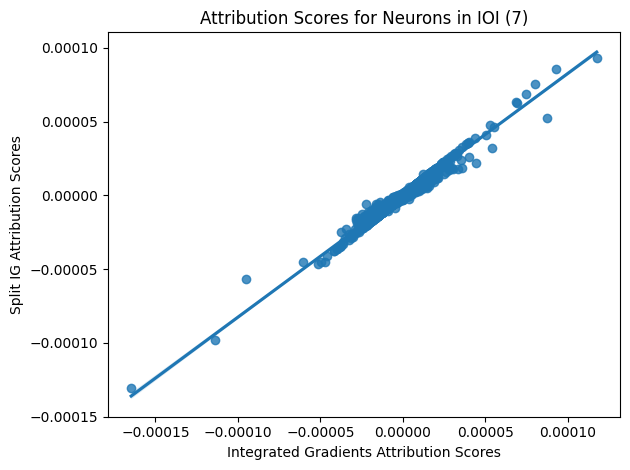

Correlation coefficient: 0.988899695478519


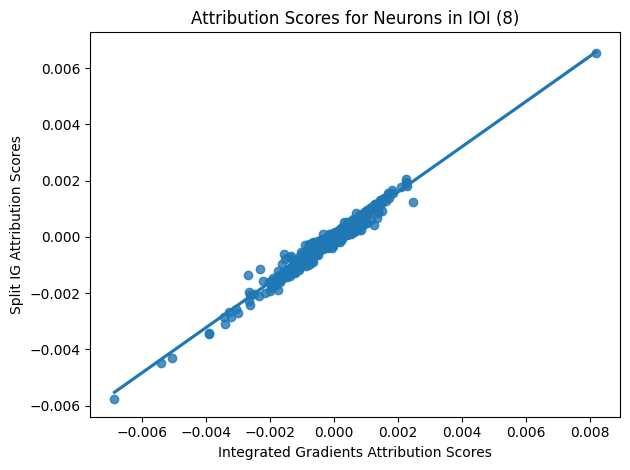

Correlation coefficient: 0.9819201722846742


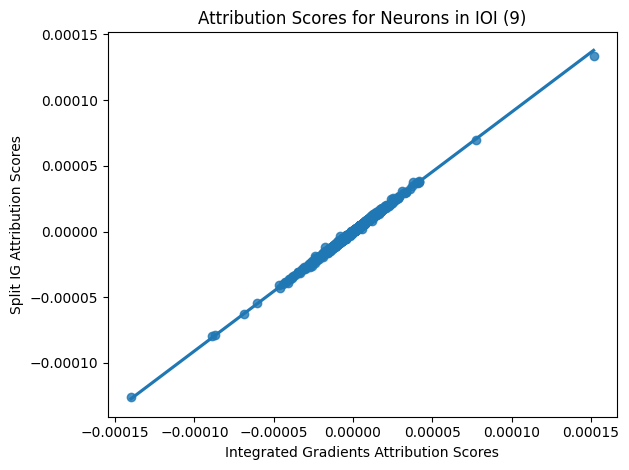

Correlation coefficient: 0.9993494955243961


In [44]:
plot_correlation(ioi_ig_mlp[:10], ioi_split_ig_mlp, "Integrated Gradients Attribution Scores", "Split IG Attribution Scores", "Attribution Scores for Neurons in IOI")


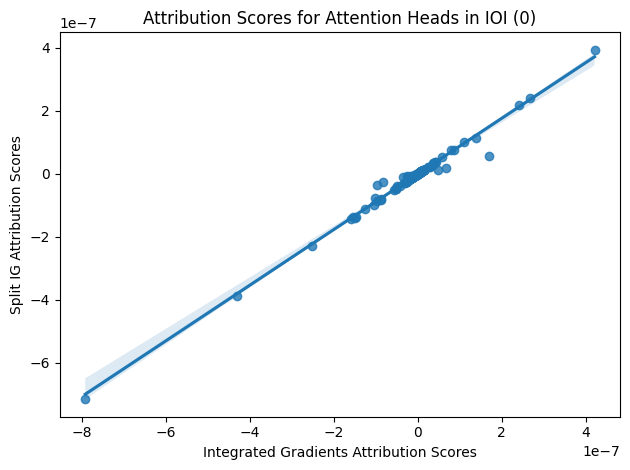

Correlation coefficient: 0.9921268107511145


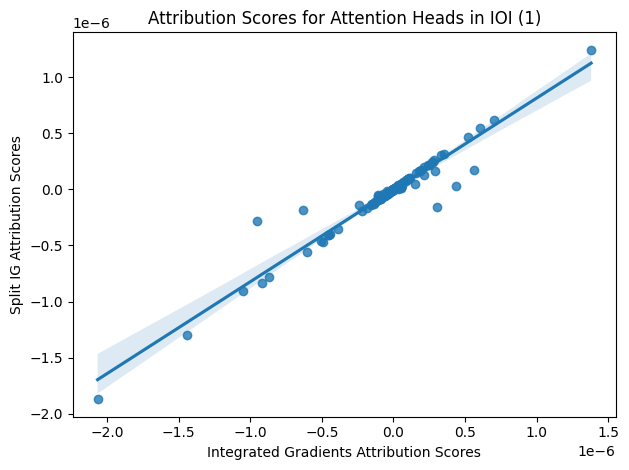

Correlation coefficient: 0.9649568700106103


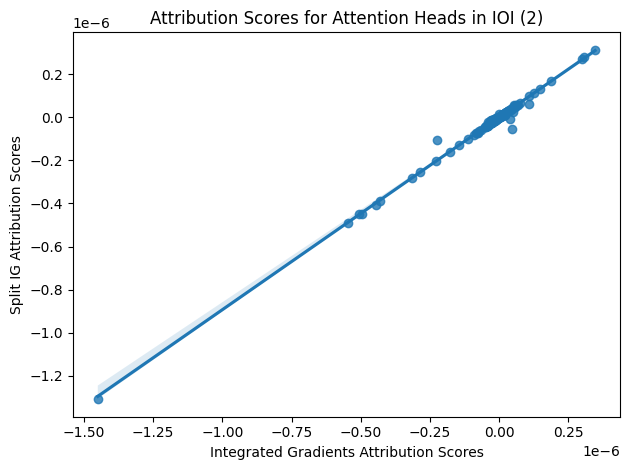

Correlation coefficient: 0.9964197992303868


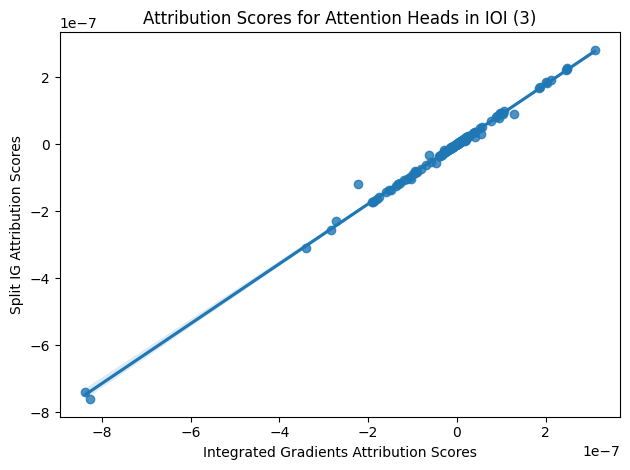

Correlation coefficient: 0.9977708529268099


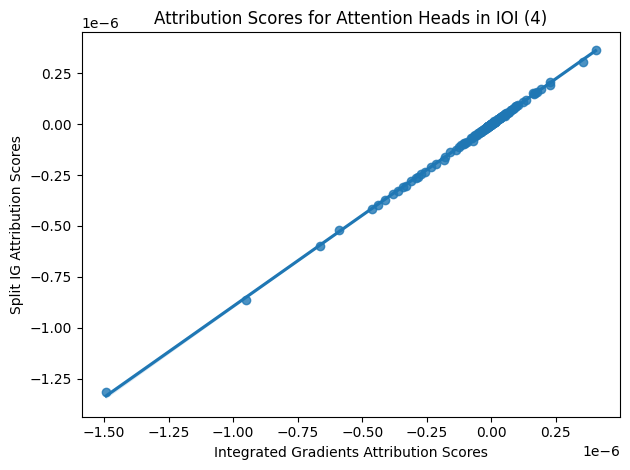

Correlation coefficient: 0.9997975546780556


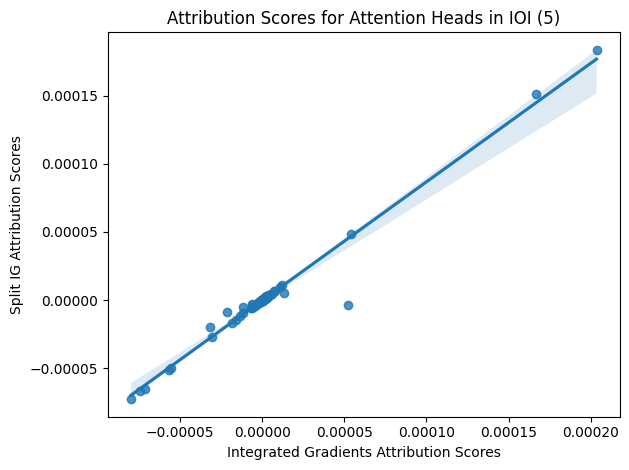

Correlation coefficient: 0.9825553501332774


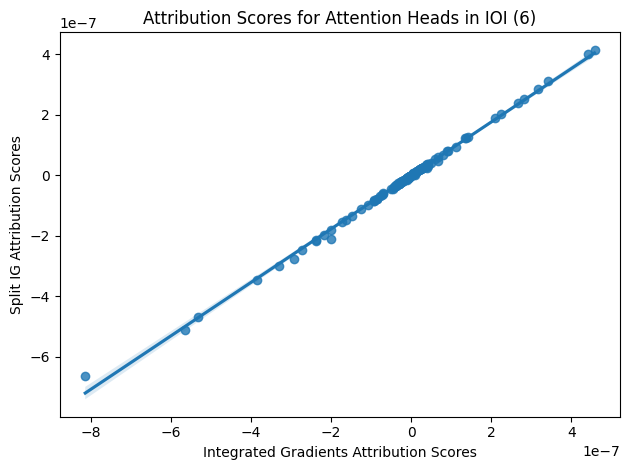

Correlation coefficient: 0.9987683901456127


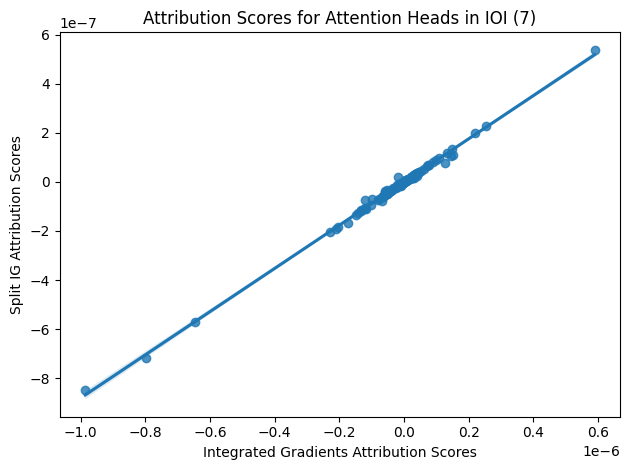

Correlation coefficient: 0.9983211032440834


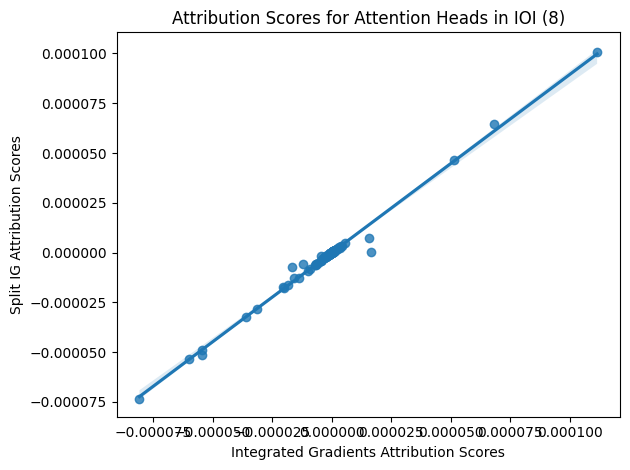

Correlation coefficient: 0.9945277413777768


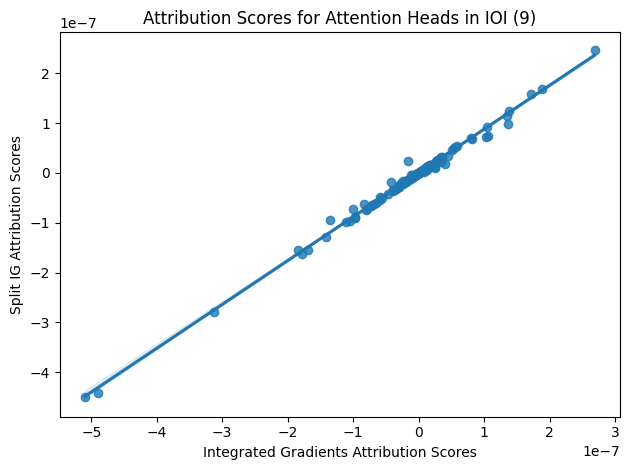

Correlation coefficient: 0.9967948292184295


In [ ]:
plot_correlation(ioi_ap_attn[:10], ioi_split_ig_attn, "Integrated Gradients Attribution Scores", "Split IG Attribution Scores", "Attribution Scores for Attention Heads in IOI")


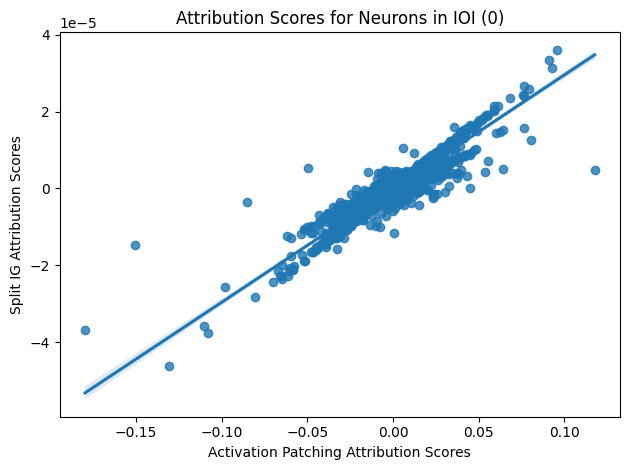

Correlation coefficient: 0.9516350244090547


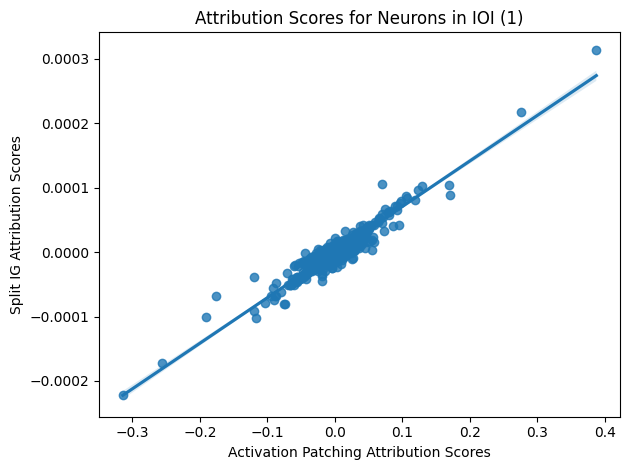

Correlation coefficient: 0.9635557597665959


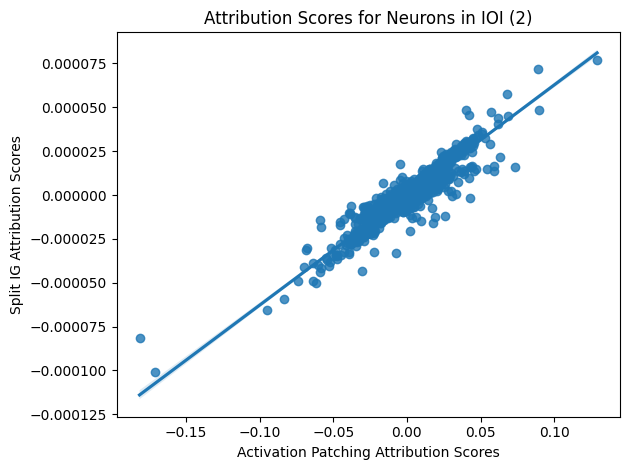

Correlation coefficient: 0.9544626953383426


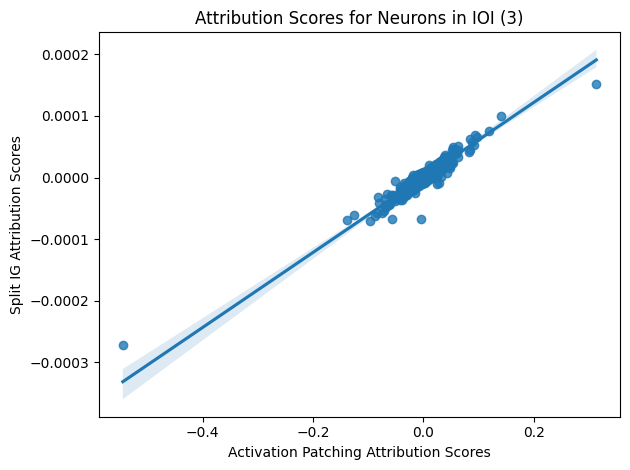

Correlation coefficient: 0.9596286787040504


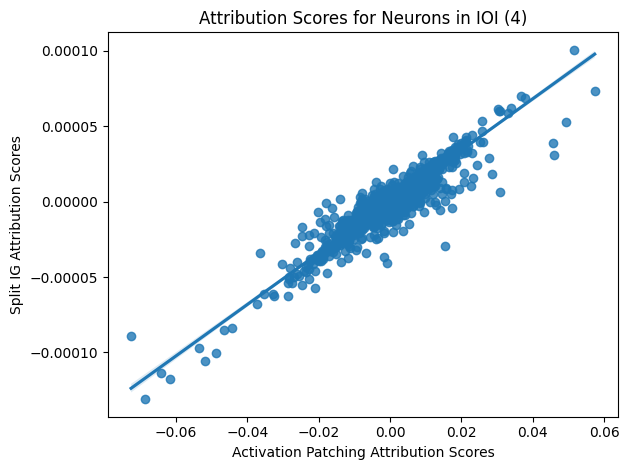

Correlation coefficient: 0.954893397105745


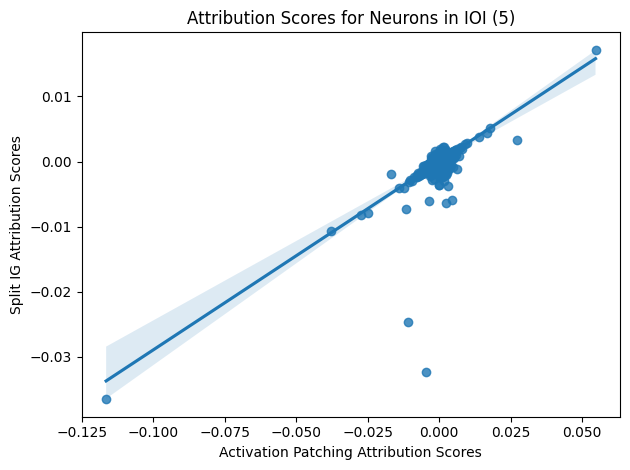

Correlation coefficient: 0.7371730306227112


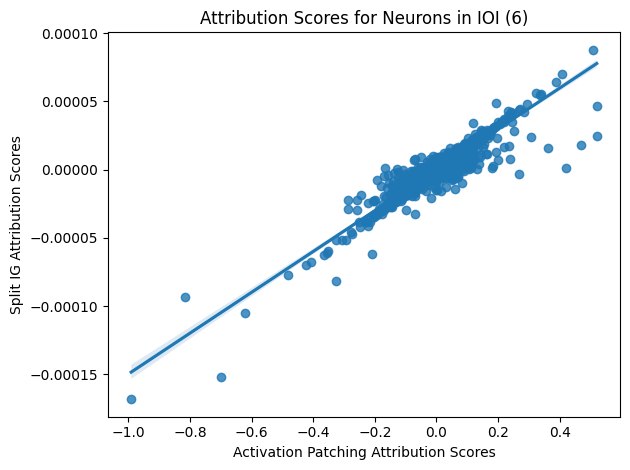

Correlation coefficient: 0.9515639025371252


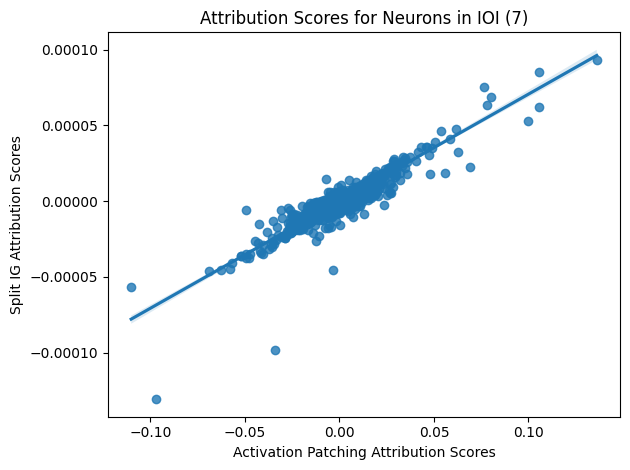

Correlation coefficient: 0.9485784811942908


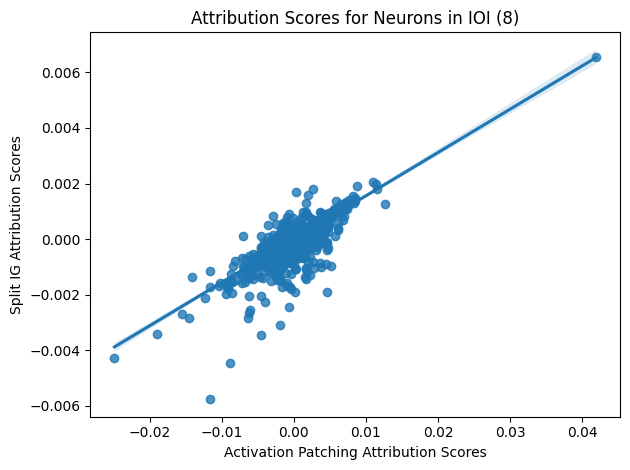

Correlation coefficient: 0.8262191861389554


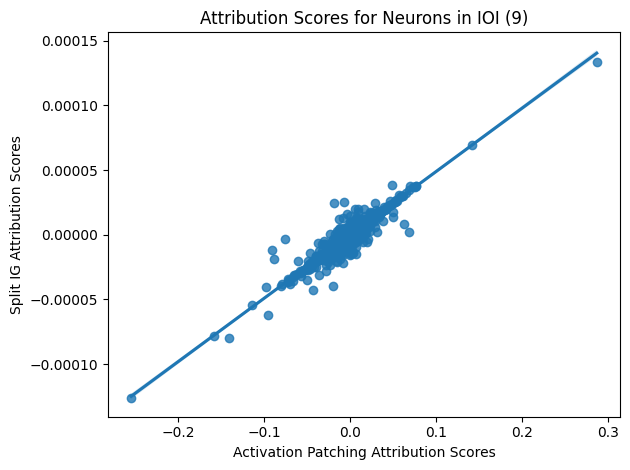

Correlation coefficient: 0.9621576802607037


In [45]:
plot_correlation(ioi_ap_mlp[:10], ioi_split_ig_mlp, "Activation Patching Attribution Scores", "Split IG Attribution Scores", "Attribution Scores for Neurons in IOI")

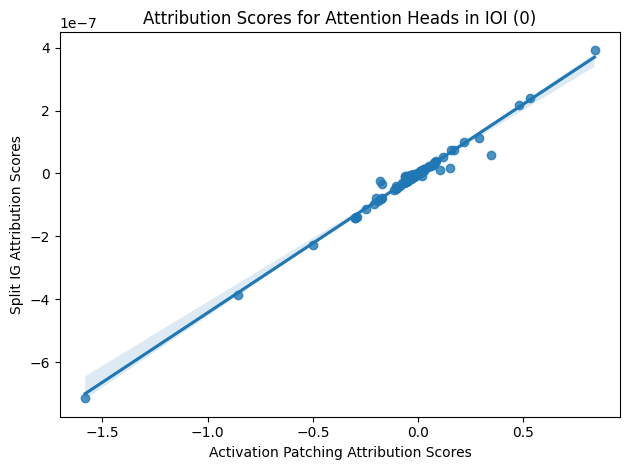

Correlation coefficient: 0.9910995479619965


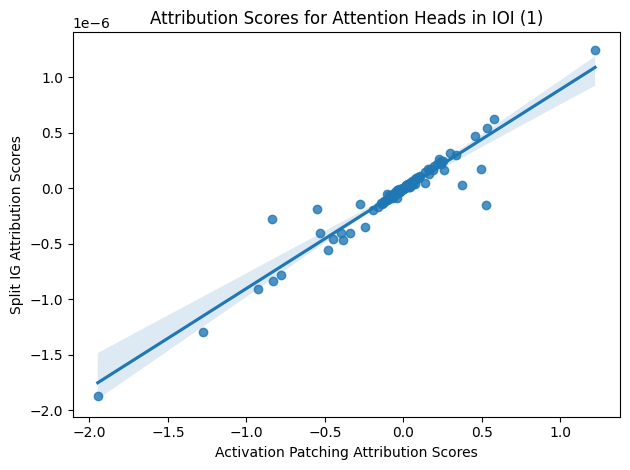

Correlation coefficient: 0.9542017425426226


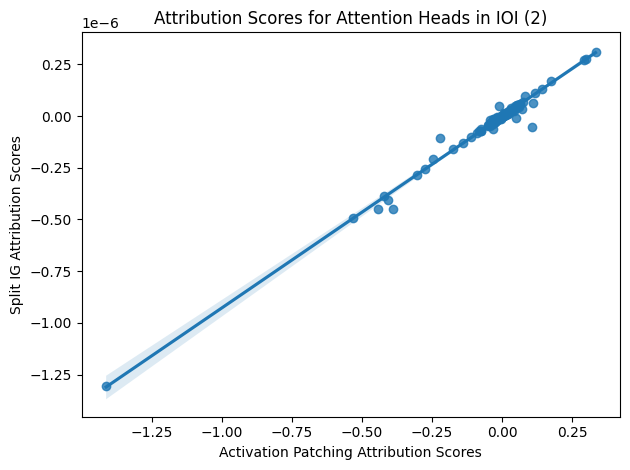

Correlation coefficient: 0.9912233622598428


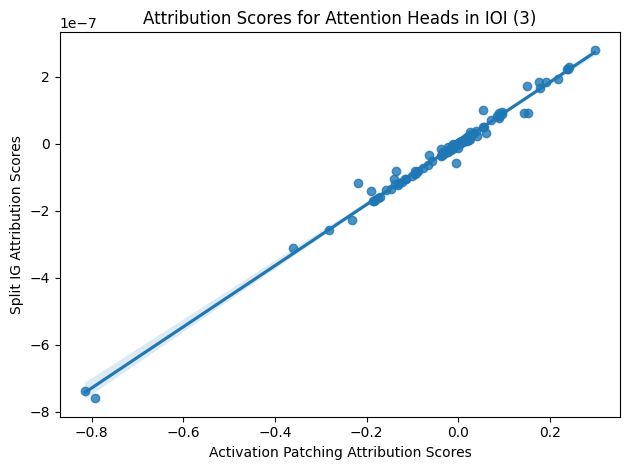

Correlation coefficient: 0.9938379430659455


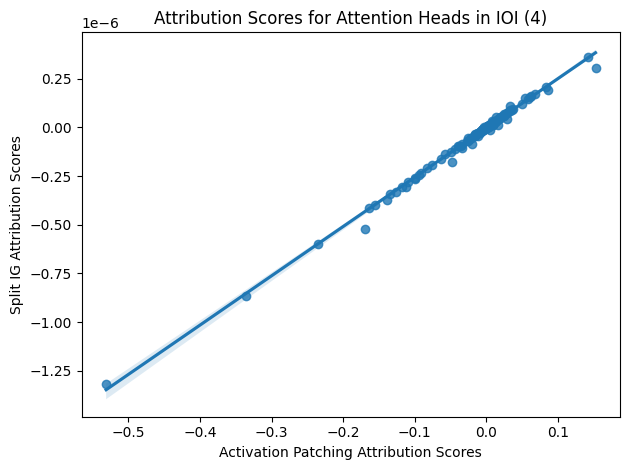

Correlation coefficient: 0.9973041979877735


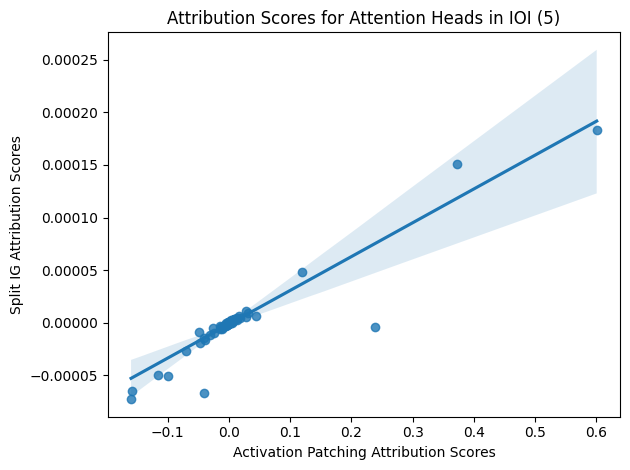

Correlation coefficient: 0.9243619717710712


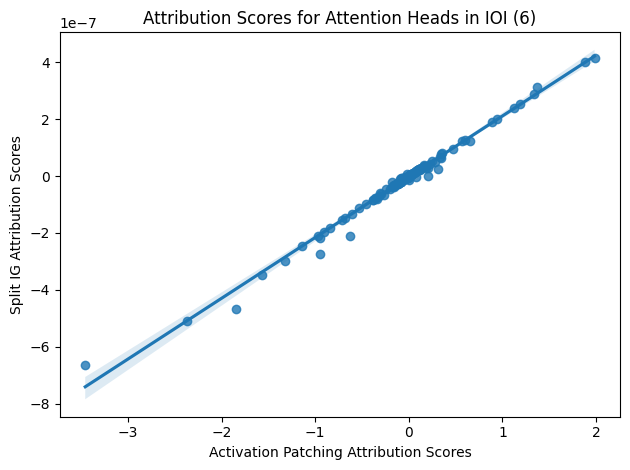

Correlation coefficient: 0.993923056938885


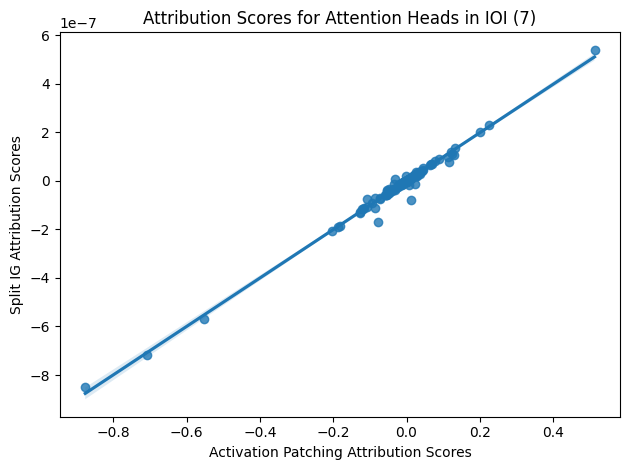

Correlation coefficient: 0.9938699156200211


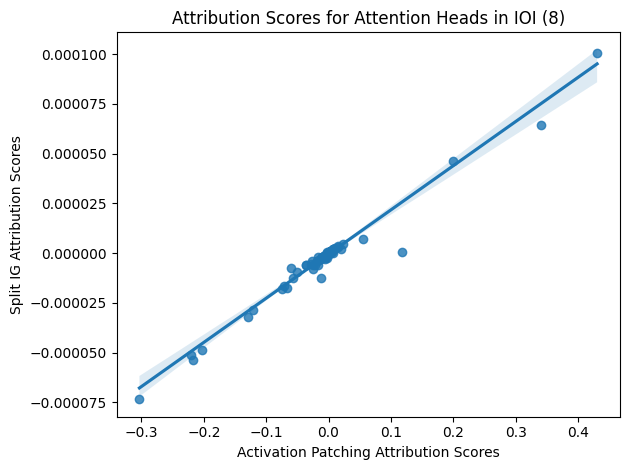

Correlation coefficient: 0.983328963199658


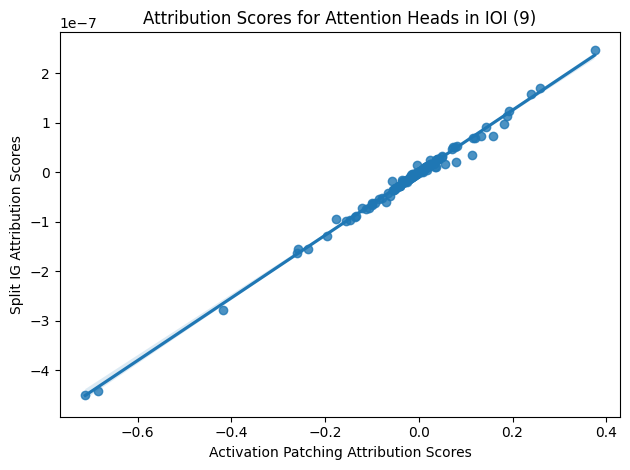

Correlation coefficient: 0.9963069698120292


In [46]:
plot_correlation(ioi_ap_attn[:10], ioi_split_ig_attn, "Activation Patching Attribution Scores", "Split IG Attribution Scores", "Attribution Scores for Attention Heads in IOI")

## Elimination of noise

We want to check if noisy (method-exclusive) components are eliminated under split IG.

To do this, we compare the attribution scores of method-exclusive components under IG and Split IG.

### Method-exclusive components in Split IG

In [74]:
print(f"Average attribution score for split IG neurons: {ioi_split_ig_mlp.mean()}")
print(f"Average attribution score for split IG attention: {ioi_split_ig_attn.mean()}")

Average attribution score for split IG neurons: -1.4675862303192844e-06
Average attribution score for split IG attention: -1.6894962584501627e-07


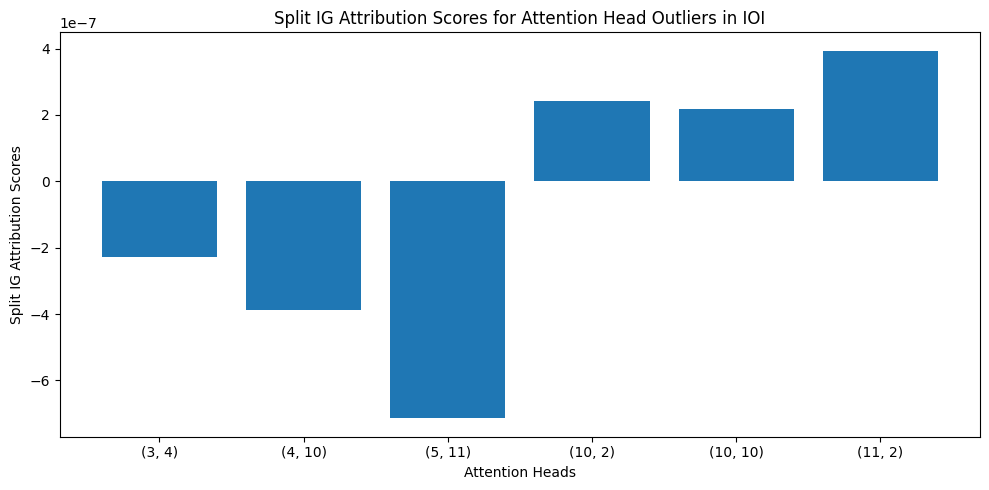

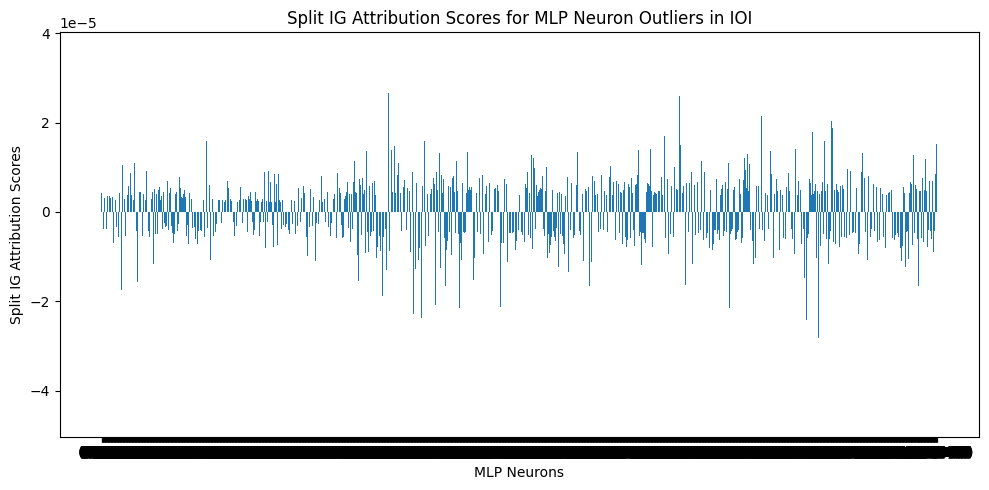

In [55]:
attn_outliers_split_ig = {(layer, idx): ioi_split_ig_attn[0][layer][idx] for layer, idx in attn_outliers[0]}
mlp_outliers_split_ig = {(layer, idx): ioi_split_ig_mlp[0][layer][idx] for layer, idx in mlp_outliers[0]}

plot_bar_chart(attn_outliers_split_ig, "Attention Heads", "Split IG Attribution Scores", "Split IG Attribution Scores for Attention Head Outliers in IOI")
plot_bar_chart(mlp_outliers_split_ig, "MLP Neurons", "Split IG Attribution Scores", "Split IG Attribution Scores for MLP Neuron Outliers in IOI")

In [57]:
diff_attn = ioi_split_ig_attn[0] - ioi_ig_attn[0]
diff_mlp = ioi_split_ig_mlp[0] - ioi_ig_mlp[0]

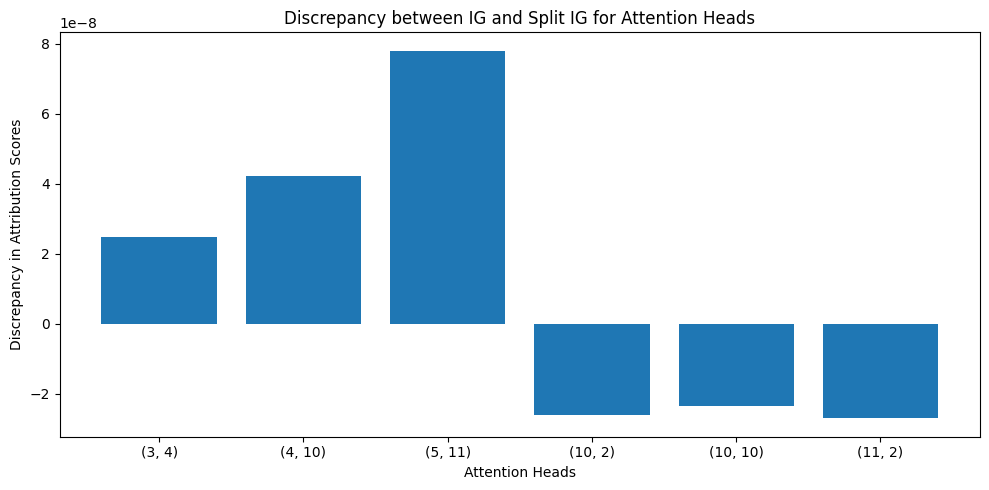

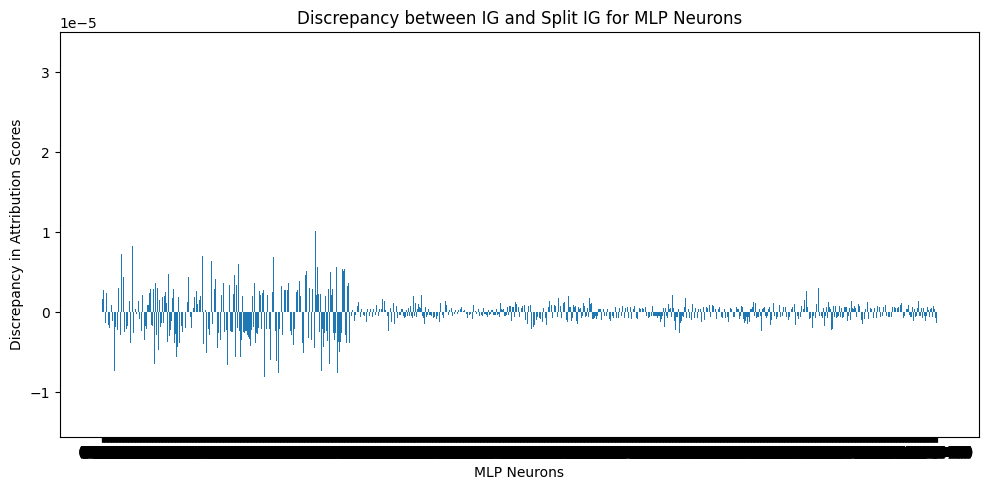

In [60]:
attn_outliers_discrepancies = {(layer, idx): diff_attn[layer][idx] for layer, idx in attn_outliers[0]}
mlp_outliers_discrepancies = {(layer, idx): diff_mlp[layer][idx] for layer, idx in mlp_outliers[0]}

plot_bar_chart(attn_outliers_discrepancies, "Attention Heads", "Discrepancy in Attribution Scores", "Discrepancy between IG and Split IG for Attention Heads")
plot_bar_chart(mlp_outliers_discrepancies, "MLP Neurons", "Discrepancy in Attribution Scores", "Discrepancy between IG and Split IG for MLP Neurons")

### Ablation of IG exclusive components

To evaluate the noisiness of IG versus Split IG, we ablate IG-exclusive and SIG-exclusive components.

In [67]:
# Get the mean activations over a corrupt dataset

attn_outlier_hooks = [get_act_name("result", layer_idx) for layer_idx in range(model.cfg.n_layers)]
mlp_outlier_hooks = [get_act_name("post", layer_idx) for layer_idx in range(model.cfg.n_layers)]

test_dataset = TaskDataset(Task.IOI)
random_dataloader = test_dataset.to_dataloader(batch_size=50, shuffle=True)
random_prompts, _, _ = next(iter(random_dataloader))

prompts_tokens = model.to_tokens(random_prompts)
_, prompt_cache = model.run_with_cache(
    prompts_tokens, 
    names_filter=lambda x: x in attn_outlier_hooks or x in mlp_outlier_hooks
)

mean_corrupt_activations = {}
for key in prompt_cache.keys():
    mean_values_over_prompts = torch.mean(prompt_cache[key], dim=0, keepdim=True)
    mean_corrupt_activations[key] = torch.mean(mean_values_over_prompts, dim=1, keepdim=True)

In [68]:
# Identify components highlighted by IG but not by Split IG
attn_ig_outliers = identify_outliers(ioi_ig_attn[0], ioi_split_ig_attn[0], only_collect_x_outliers=True)
mlp_ig_outliers = identify_outliers(ioi_ig_mlp[0], ioi_split_ig_mlp[0], only_collect_x_outliers=True)

# Ablate the components highlighted by IG but not by Split IG
ig_only_attn_ablated_scores = dict()
for layer, idx in attn_ig_outliers:
    performance = test_single_ablated_performance(model, layer, idx, mean_corrupt_activations, Task.IOI, is_attn=True)
    ig_only_attn_ablated_scores[(layer, idx)] = performance

ig_only_mlp_ablated_scores = dict()
for layer, idx in mlp_ig_outliers:
    performance = test_single_ablated_performance(model, layer, idx, mean_corrupt_activations, Task.IOI, is_attn=False)
    ig_only_mlp_ablated_scores[(layer, idx)] = performance

Test IOI performance with ablated (0, 1)
Mean performance: 0.7649935483932495
Test IOI performance with ablated (0, 6)
Mean performance: 0.6848785877227783
Test IOI performance with ablated (0, 10)
Mean performance: 0.5845374464988708
Test IOI performance with ablated (0, 3)
Mean performance: 0.6611246466636658
Test IOI performance with ablated (0, 34)
Mean performance: 0.6603348255157471
Test IOI performance with ablated (0, 64)
Mean performance: 0.6599902510643005
Test IOI performance with ablated (0, 73)
Mean performance: 0.6614609956741333
Test IOI performance with ablated (0, 81)
Mean performance: 0.6601555347442627
Test IOI performance with ablated (0, 88)
Mean performance: 0.6615196466445923
Test IOI performance with ablated (0, 89)
Mean performance: 0.6614376902580261
Test IOI performance with ablated (0, 106)
Mean performance: 0.6609525084495544
Test IOI performance with ablated (0, 117)
Mean performance: 0.6612861156463623
Test IOI performance with ablated (0, 127)
Mean perfo

In [72]:
torch.save(ig_only_attn_ablated_scores, "results/saturated/ig_only_attn_ablated_scores.pt")
torch.save(ig_only_mlp_ablated_scores, "results/saturated/ig_only_mlp_ablated_scores.pt")

In [69]:
# Identify components highlighted by Split IG but not by IG
split_ig_only_attn_outliers = identify_outliers(ioi_split_ig_attn[0], ioi_ig_attn[0], only_collect_x_outliers=True)
split_ig_only_mlp_outliers = identify_outliers(ioi_split_ig_mlp[0], ioi_ig_mlp[0], only_collect_x_outliers=True)

# Ablate the components highlighted by Split IG but not by IG
split_ig_only_attn_ablated_scores = dict()
for layer, idx in split_ig_only_attn_outliers:
    performance = test_single_ablated_performance(model, layer, idx, mean_corrupt_activations, Task.IOI, is_attn=True)
    split_ig_only_attn_ablated_scores[(layer, idx)] = performance
    
split_ig_only_mlp_ablated_scores = dict()
for layer, idx in split_ig_only_mlp_outliers:
    performance = test_single_ablated_performance(model, layer, idx, mean_corrupt_activations, Task.IOI, is_attn=False)
    split_ig_only_mlp_ablated_scores[(layer, idx)] = performance

Test IOI performance with ablated (0, 4)
Mean performance: 0.6740017533302307
Test IOI performance with ablated (0, 8)
Mean performance: 0.6731716394424438
Test IOI performance with ablated (4, 10)
Mean performance: 0.6555951833724976
Test IOI performance with ablated (5, 11)
Mean performance: 0.621489405632019
Test IOI performance with ablated (0, 0)
Mean performance: 0.6607372760772705
Test IOI performance with ablated (0, 5)
Mean performance: 0.6605187058448792
Test IOI performance with ablated (0, 30)
Mean performance: 0.6610783338546753
Test IOI performance with ablated (0, 31)
Mean performance: 0.6602554321289062
Test IOI performance with ablated (0, 36)
Mean performance: 0.6610196828842163
Test IOI performance with ablated (0, 44)
Mean performance: 0.6600164175033569
Test IOI performance with ablated (0, 61)
Mean performance: 0.6624548435211182
Test IOI performance with ablated (0, 97)
Mean performance: 0.6611201763153076
Test IOI performance with ablated (0, 115)
Mean performan

In [73]:
torch.save(split_ig_only_attn_ablated_scores, "results/saturated/split_ig_only_attn_ablated_scores.pt")
torch.save(split_ig_only_mlp_ablated_scores, "results/saturated/split_ig_only_mlp_ablated_scores.pt")

#### Results

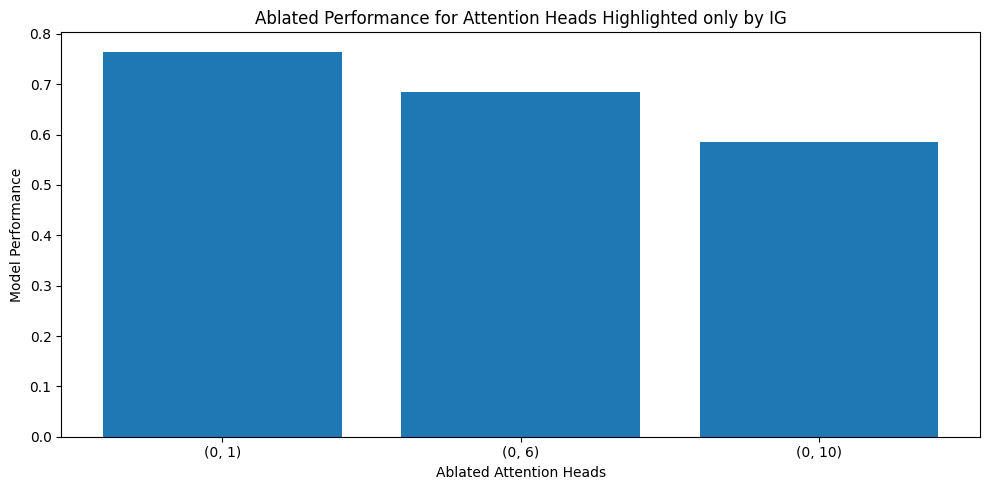

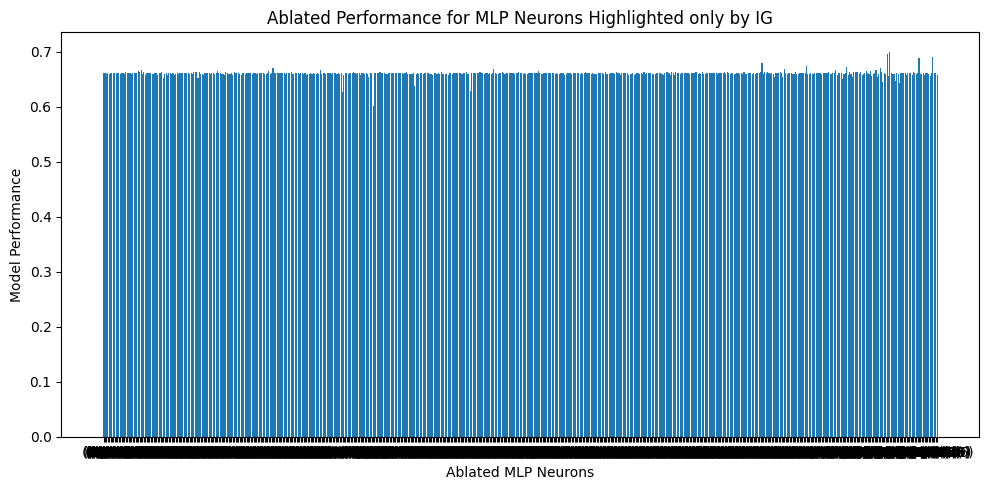

In [70]:
plot_bar_chart(ig_only_attn_ablated_scores, "Ablated Attention Heads", "Model Performance", "Ablated Performance for Attention Heads Highlighted only by IG")
plot_bar_chart(ig_only_mlp_ablated_scores, "Ablated MLP Neurons", "Model Performance", "Ablated Performance for MLP Neurons Highlighted only by IG")

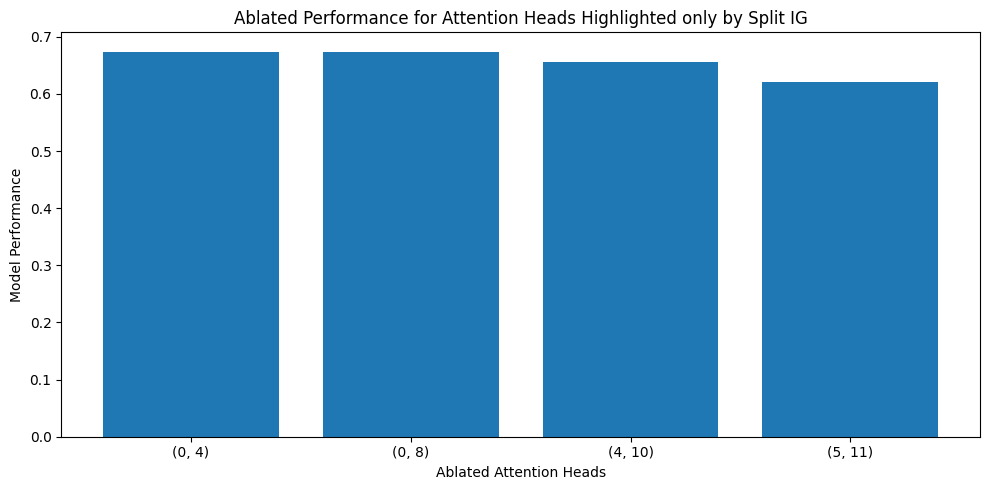

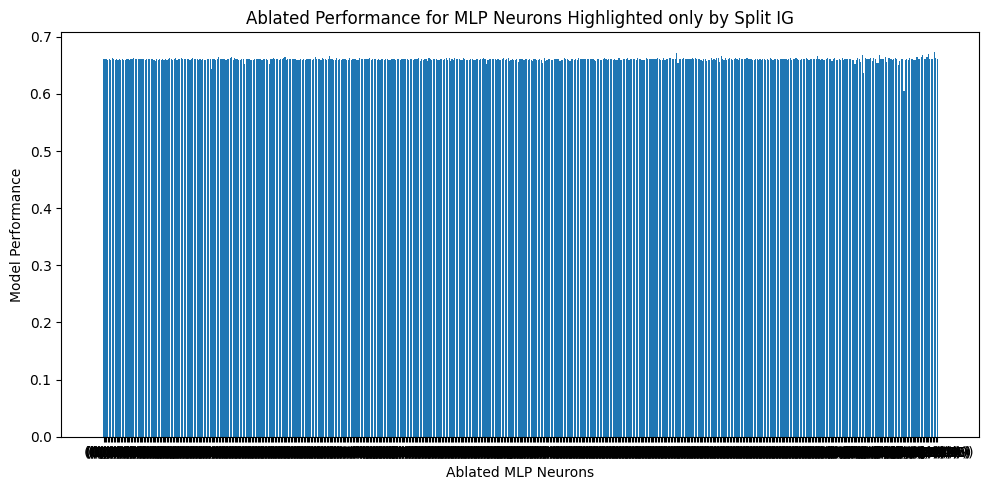

In [71]:
plot_bar_chart(split_ig_only_attn_ablated_scores, "Ablated Attention Heads", "Model Performance", "Ablated Performance for Attention Heads Highlighted only by Split IG")
plot_bar_chart(split_ig_only_mlp_ablated_scores, "Ablated MLP Neurons", "Model Performance", "Ablated Performance for MLP Neurons Highlighted only by Split IG")